**NLP Analysis - Reviews Data**

# Introduction

In the following notebook, I will be performing an NLP analysis of San Francisco Airbnb review data from December 2018 - December 2019.

My goal in this analysis is to find insights to answer the following questions:
- What are some things that hosts makes a positive user experience? What about a negative user experience? What are the commonalities among them within the review data?
- How would you advise a first time Airbnb host to ensure a great user experience? What are some goods/additional services a new host can provide to help ensure continued business on the Airbnb platform?

## Read in libraries, data, and set notebook preferences

**Read in libraries**

In [76]:
#Read in libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

**Read in data**

In [77]:
#Set path to data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\03_Processed'

#Read in data
df = pd.read_csv(path + '/2020_0208_Reviews_Processed_NLP.csv',sep=',',
                 parse_dates=['date'])

**Set preferences for notebook**

In [78]:
#Ignore warnings
import warnings; warnings.simplefilter('ignore')

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_colwidth',500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

#Set style for plots
plt.style.use('Solarize_Light2')

## Preview data

In [79]:
print('Reviews data shape:', df.shape)
display(df.head())

Reviews data shape: (65049, 5)


,comments,date,sentiment_compound,label,word_count
0,"Our San Francisco stay with Sharna was very disappointing My husband has mobility problems, so I checked beforehand to find out if the stairs to her second-floor condo were steep. Sharna said no. But it turned out that her second floor condo was actually on the third floor and required my husband to climb 50 steps to get to our bedroom! Key problems: First, rang the doorbell (which didn’t work). After we banged for a while on the outside door, Sharna appeared. No smile or hello....",2013-08-02,-0.9907,negative,461
1,"The location was great, yes it did have a great view, but it was dirty. The first thing I do anywhere is pull back the top sheet. There was a bunch of crunchy things and hair on the sheets and pillow case. The top sheet was torn in several places and the pillow cases had holes in them. They were not changed. I had no place to stay so I brushed them off and spent two uncomfortable nights in the house. The bathtub/shower was dirty and had black mold around where the wall met the tub....",2013-11-01,-0.8452,negative,241
2,"Host was very friendly. The block where this Air BnB is, was fine, but Haight is still a bit unsavory.",2015-06-08,-0.5082,negative,20
3,"I have stayed in many airbnb, always met host, on arrival, questions answered etc,, that did not occur, and then lock issue, none complanied re the locks so then new locks placed, but arrived and noticed new lock , but no code given to us,, had to call host in late hours ,, all unnecessary hassle.",2016-06-26,-0.4215,negative,56
4,"Gabriels spot is small but great for the price & for a couple if your in town just for a couple nights. Quiet neighborhood up on the hill close enough to walk although I do suggest you take a car service home after cause some of those SF hills are brutal after a long day. Only thing that was kinda a bummer was the shower water pressure is non existent after a long day in the city. Overall though, nice small place to stay if you plan on being out in the city most of the time which you shou...",2016-01-26,-0.3297,negative,107


# Data Exploration

## Histogram of VADER sentiment scores

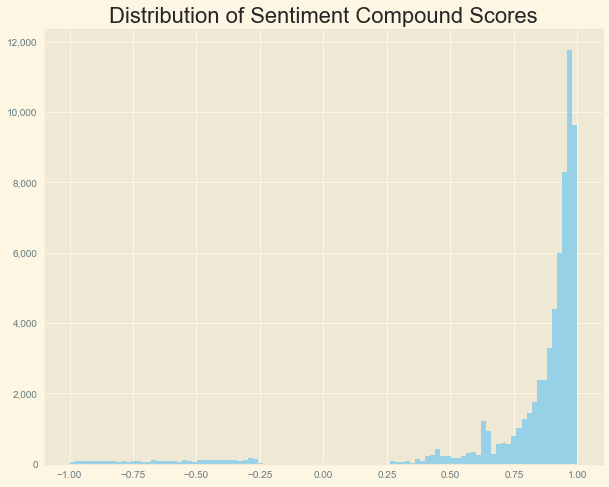

In [80]:
#Set plot
fig, ax = plt.subplots(figsize = (10,8))

#Plot hist of sentiment_compound scores
j = df.sentiment_compound.hist(ax = ax,bins = 100, color = 'skyblue', alpha = .85)

#Set plot aesthetics
j.set_title('Distribution of Sentiment Compound Scores', fontsize = 22)
ax.set_yticklabels(['{:,}'.format(int(y)) for y in ax.get_yticks()]);

## Positive, neutral, and negative review label counts

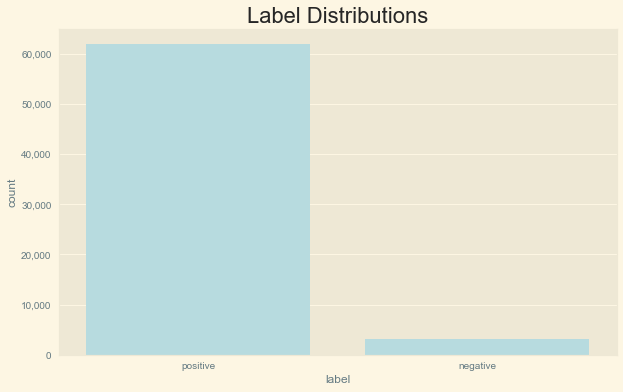

In [81]:
#Set plot
fig, ax = plt.subplots(figsize=(10,6))

#plot data
g =sns.countplot(x='label', data = df,order = ['positive', 'negative'], color='powderblue')

#Set plot aesthetics
g.set_title('Label Distributions', fontsize = 22)
g.set_yticklabels(['{:,}'.format(int(y)) for y in ax.get_yticks()]);

## Distribution of word counts for positive and negative reviews

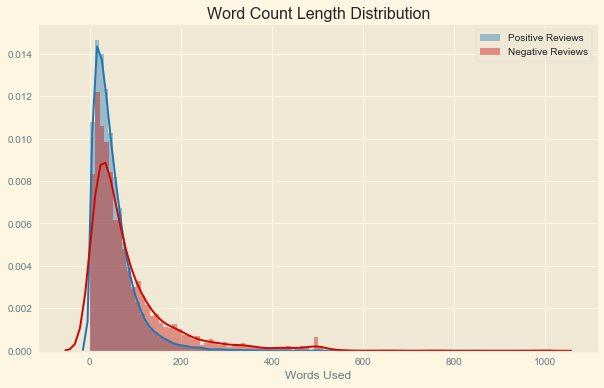

In [82]:
#Create pos/negative df's
pos_df = df[df.label == 'positive']
neg_df = df[df.label == 'negative']

#Create pos/neg corpora
pos_comments = pos_df['comments'].tolist()
neg_comments = neg_df['comments'].tolist()

#Set plot
fig, ax = plt.subplots(figsize=(10,6))

#Plot Histograms for word count
sns.distplot(pos_df.word_count, kde = True, bins = 100, color = 'tab:blue', ax=ax)
sns.distplot(neg_df.word_count, kde = True, bins = 100, color = 'r', ax=ax)

#Set plot aesthetics
ax.legend(labels = ['Positive Reviews', 'Negative Reviews', 'Neutral Reviews'], frameon = True);
ax.set_title('Word Count Length Distribution')
ax.set_xlabel('Words Used');

## Word clouds and frequency counts of positive and negative reviews

In [83]:
#Import wordcloud libraries 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

#Import stopwords
from nltk.corpus import stopwords, wordnet
stop_words = stopwords.words('english')

#Add additional stop words
stop_words.extend(['airbnb','website hidden by airbnb'])

#Import libraries for word count visualization
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text.freqdist import FreqDistVisualizer

### Postive Reviews 

**WordCloud**

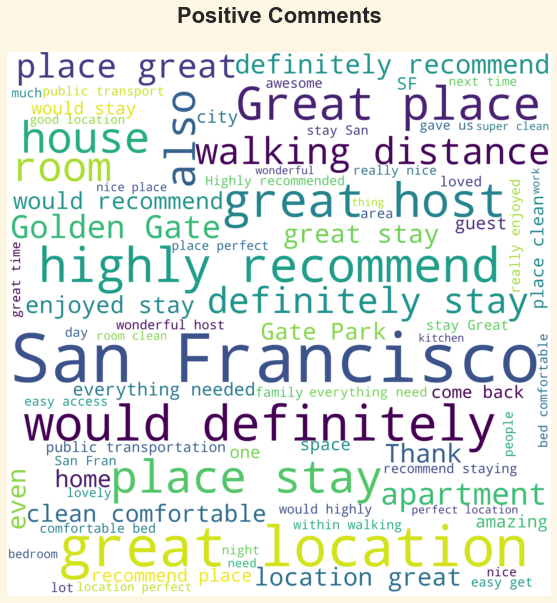

In [84]:
#Create wordcloud for postive reviews
wordcloud = WordCloud(max_font_size=500, max_words=80, background_color="white", stopwords=stop_words,
                      width= 4000, height = 4000).generate(str(pos_comments))

#Plot data and set plot aesthetics
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Positive Comments\n', fontsize=22, fontweight='bold')
plt.show()

**Positive Word Frequency Distributions**

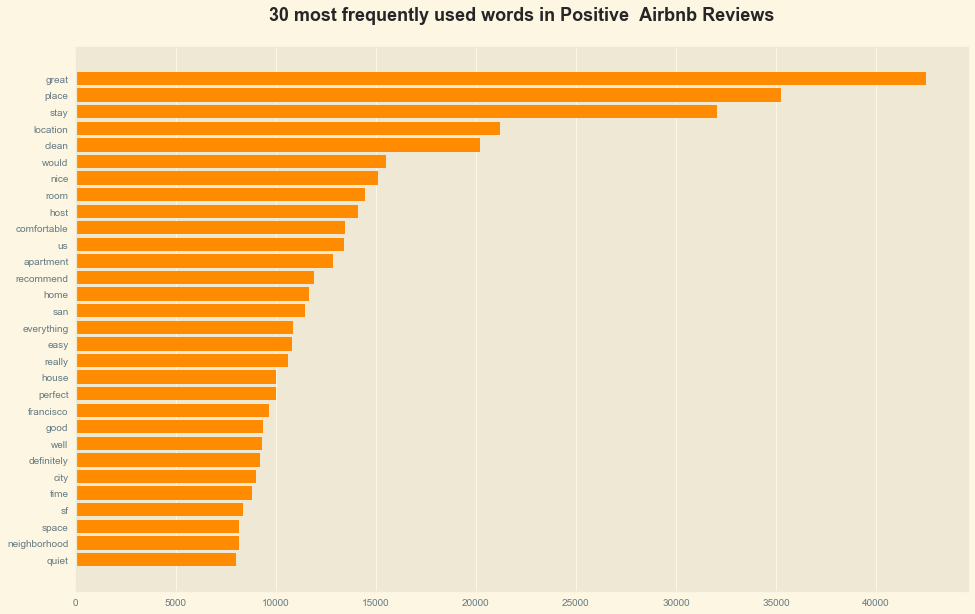

In [85]:
#Vectorize comments and also remove stop words
cv = CountVectorizer(stop_words=stop_words)
positive_docs = cv.fit_transform(pos_comments)
features = cv.get_feature_names()

#Preparing the plot
plt.figure(figsize=(16,10))
plt.title('30 most frequently used words in Positive  Airbnb Reviews\n', fontsize = 18, fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30, orient='h', color = 'darkorange')
visualizer.fit(positive_docs)
visualizer.poof;

### Negative Reviews

**WordCloud**

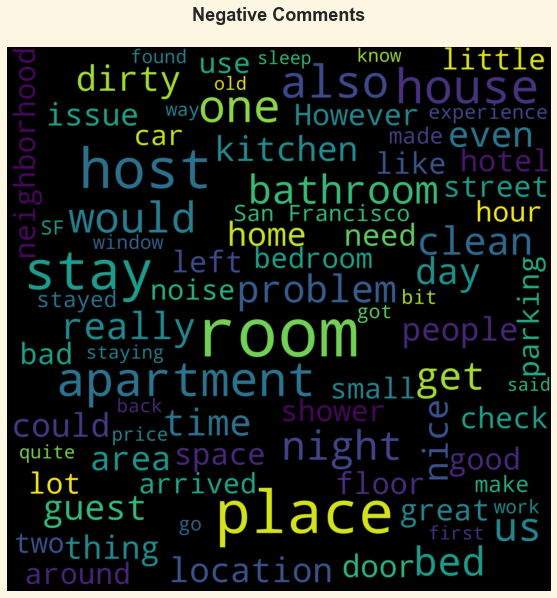

In [86]:
#Create wordcloud for postive reviews
wordcloud = WordCloud(max_font_size=500, max_words=80, background_color="black",stopwords=stop_words,
                      width= 4000, height = 4000).generate(str(neg_comments))

#Plot data and set plot aesthetics
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Negative Comments\n', fontsize=18, fontweight='bold')
plt.show()

**Negative Word Frequency Distributions**

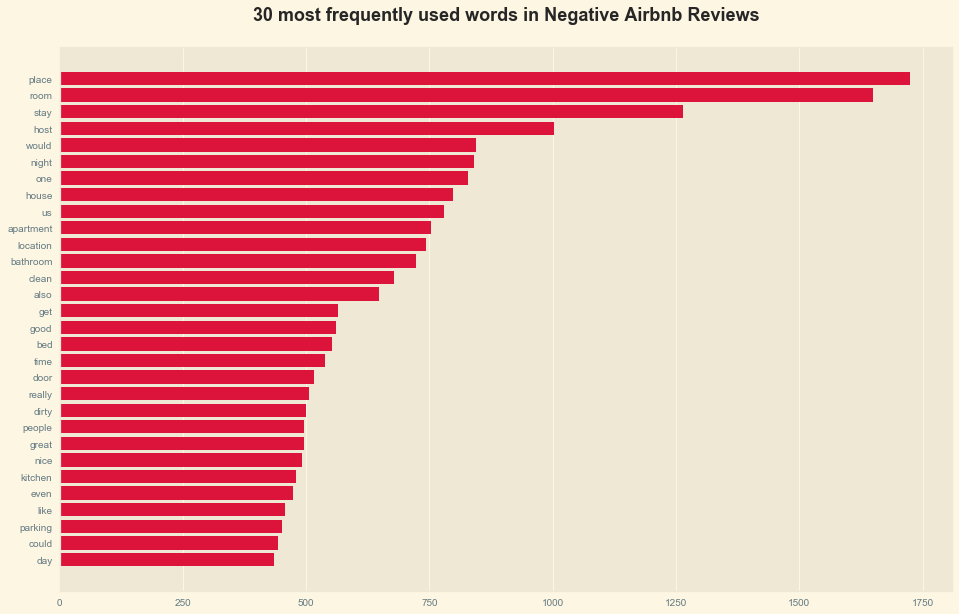

In [87]:
#Vectorize comments and also remove stop words
cv = CountVectorizer(stop_words=stop_words)
negative_docs = cv.fit_transform(neg_comments)
features = cv.get_feature_names()

#Preparing the plot
plt.figure(figsize=(16,10))
plt.title('30 most frequently used words in Negative Airbnb Reviews\n', fontsize = 18, fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30, orient='h',color='crimson')
visualizer.fit(negative_docs)
visualizer.poof;

# Topic Modeling for Positive Reviews

## Import libraries

In [88]:
# Gensim
import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Import spacy for lemmatization
from spacy.lang.en import English
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

#Reg exp
import re

#LDA model plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt

## Data Preparation

### Functions for data cleaning, tokenization, and lemmatization

In [89]:
#Raw data tokenizer/simple processor 
def tokenizer(raw_reviews):
    """
    Takes raw text data.
    Yields a tokenized version of raw data w/ punctuation removed and all characters in lowercase
    """
    for review in raw_reviews:
        yield(gensim.utils.simple_preprocess(review, deacc=True))
        
#Clean up raw tokens
def remove_stopwords(tokens):
    """
    Remove stopwords and words < 3 characters in length from tokenized comments
    """
    tokens = [tokens.remove(token) if len(token) <3 else token for token in tokens] 
    tokens = [token for token in tokens if token] #Remove None from tokens
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tokens]

#Lemmatize cleaned tokens
def lemmatization(cleaned_tokens, pos_tags = ['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    Lemmatize CLEANED tokens with specified pos tags and append to lemmatized_text. 
    Default pos_tags = ['NOUN', 'ADJ', 'VERB', 'ADV'] 
    """
    for item in cleaned_tokens:
        doc = nlp(" ".join(item))
        lemmatized_text.append([token.lemma_ for token in doc if token.pos_ in pos_tags])
    return lemmatized_text

#Create bigrams
def bigrams(tokens):
    return[bigram_mod[token] for token in tokens]

#Create trigrams
def trigrams(tokens):
    return[trigram_mod[bigram_mod[token]] for token in tokens]

### Clean-up raw data. Create bi & trigrams

**Tokenize raw comments**

In [90]:
#Tokenize pos_comments and remove puncuation
pos_tokens = list(tokenizer(pos_comments))

**Create bigram and trigram models**

In [91]:
#Build bigram and trigram models
bigram = gensim.models.Phrases(pos_tokens,min_count=5, threshold=100)#Might need to increse with full data set
trigram = gensim.models.Phrases(bigram[pos_tokens], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Remove stopwords, create trigrams, and lemmatize

In [ ]:
#Remove stopwords from pos_tokens
pos_tokens_clean = remove_stopwords(pos_tokens)

#Create trigrams from cleaned tokens
pos_trigrams = trigrams(pos_tokens_clean)

#Init spacy 'en' model keeping only tagger component 
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

#Init empty list to append lemmatized tokens to
lemmatized_text = []

#Lemmatize noun, adj, vb, adv
data_lemmatized = lemmatization(list(pos_trigrams),pos_tags = ['NOUN', 'ADJ', 'VERB', 'ADV'])

#Check
print(data_lemmatized[0])

### Create Bag of Words and normalize with TF-IDF

**Create bow_corpus**

In [ ]:
#Create dictionary of words from lemmatized data
dictionary = corpora.Dictionary(documents=data_lemmatized)

#Filter dictionary and remove words that apppear in < 15 documents and in more than 50% of the documents
dictionary.filter_extremes(no_below=15, no_above=0.5)

#Create BoW and view # of unique words
bow_corpus = [dictionary.doc2bow(text) for text in data_lemmatized]
print('Number of unique words in dictionary for positive reviews:', len(dictionary))

#Preview Bag Of Words
bow_doc_1 = bow_corpus[0]
for i in range(len(bow_doc_1)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_1[i][0], 
                                               dictionary[bow_doc_1[i][0]], bow_doc_1[i][1]))

**Compute term frequency in bow_corpus and normalize w/ TF-IDF**

In [ ]:
#Init TfidfModel
tfidf = models.TfidfModel(bow_corpus)

#Transform bow_corpus with tfidf
corpus_tfidf = tfidf[bow_corpus]

#Check first document
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

## Topic Modeling with LDA

### Find optimal number of topics using coherence score

In [ ]:
#Get coherence scores 
def get_coherence_values(dictionary, corpus, texts, max_topics, start=2, step=3):
    """
    Compute the coherence score for different LDA models
    of different topic numbers
    ----------------------------------------------------
    PARAMETERS:
    - dictionary : Gensim dictionary
    - corpus : Gensim corpus
    - texts : List of input texts
    - limit : Max num of topics 
    """
    coherence_scores = []
    model_list = []
    for topics in range(start, max_topics, step):
        model = gensim.models.LdaMulticore(corpus = corpus, num_topics=topics,workers=3, id2word=dictionary, random_state=24)
        model_list.append(model)
        coherence_model = CoherenceModel(model = model, texts=texts, dictionary=dictionary)
        coherence_scores.append(coherence_model.get_coherence())
    return model_list, coherence_scores

In [ ]:
#Set parameters for topic count in _coherence_values
start=2; max_topics=20; step=2;

#Init coherenc scores for LDA model with a max of 20 topics
models, scores = get_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, 
                                                    texts=data_lemmatized, start=start, max_topics=max_topics, step=step)

#Create list of topic counts to view/visualize coherence scores 
x= list(range(start, max_topics, step))

#Print coherence scores
for m, cv in zip(x, scores):
    print('Coherence Score for LDA w/', m,'topics:', round(cv,3))

#Set plot size
plt.figure(figsize=(10,7))

#Plot coherence scores
plt.plot(x,scores, label = 'Coherence Score', color='green', marker='o', linestyle='-',
      linewidth=2, markersize=5, )

plt.title('Coherence score by number of topics', fontsize = 18, fontweight='bold')
plt.legend(frameon = True, shadow = True)
plt.show();

### Build optimal LDA model, calculate model perplexity and visualize topics

In [ ]:
#Init optimal model with the optimal number of topics(8 topics)
optimal_model = gensim.models.LdaMulticore(corpus=corpus_tfidf,id2word=dictionary,
                                           num_topics=8, random_state=24,
                                       chunksize=100,passes=100)


#Save optimal model
optimal_model.save('Positive_Reviews_LDA.model')

#Compute LDA model perplexity
print('Optimal LDA Model Perplexity: ', optimal_model.log_perplexity(corpus_tfidf))

# Compute Coherence Score
from gensim.models import CoherenceModel
optimal_model_coherence = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nOptimal LDA Model Coherence Score: ', optimal_model_coherence.get_coherence())

#View 8 topics
print('\nOptimal LDA Model Topics:')
display(optimal_model.print_topics())

In [ ]:
#Visulize topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus_tfidf, dictionary)
vis

### Additional insights into topics

**Find dominant topic for each review and view topic distribution in positive reviews**

In [ ]:
#Write function that assigns topic to each 
def topic_finder(ldamodel, corpus, text):
    """
    Returns dataframe containing dominant topic 
    for each individual review
    """
    topics = pd.DataFrame()
    
    #Get main topic of each doc
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key = lambda x: (x[1]), reverse = True)
    #Get the dominant topic, percent contribution, and keywords for each document
        for j,(topic_num, prop_topic) in enumerate(row):
            if j == 0: #Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topics = topics.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    #Rename columns
    topics.columns = ['Dominant_Topic', 'Percent_Contribution', 'Topic_Keywords']
    #Append original comments to pos_topics
    comments = pd.Series(text)
    topics = pd.concat([topics, comments], axis = 1)
    return topics   

In [ ]:
#Find dominant topic for each review
positive_topics = topic_finder(optimal_model,corpus_tfidf, pos_comments)

#Format positive_topics
positive_topics.columns = ['Dominant_Topic', 'Topic%_Contribution','Keywords', 'Reviews']

#View distribution of topics across all positive reviews
positive_topics.groupby('Dominant_Topic')['Dominant_Topic'].count().plot(kind = 'bar')

**Extract 3 most representative documents for each positive topic**

In [ ]:
#Subset 3 largest topic contributors per topic and get index
top_docs = positive_topics.groupby('Dominant_Topic')['Topic%_Contribution'].nlargest(3).reset_index()
rows = list(top_docs['level_1'])

#View comments that contribute the most to each topic
positive_topics.iloc[(rows)]

# Negative Reviews

## Data preparation

**Tokenize raw comments**

In [ ]:
#Tokenize negative raw comments
neg_tokens = list(tokenizer(neg_comments))

**Create bigram and trigram models**

In [ ]:
#Build bigram and trigram models on neg_tokens
bigram = gensim.models.Phrases(neg_tokens,min_count=5, threshold=10)
trigram = gensim.models.Phrases(bigram[neg_tokens], threshold=10)

#Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

**Remove stopwords from neg tokens, create trigrams, and lemmatize**

In [ ]:
#Remove stopwords
neg_tokens_cleaned = remove_stopwords(neg_tokens)

#Create trigrams
neg_trigrams = trigrams(neg_tokens_cleaned)


#Initialize spacy 'en' model keeping only tagger component 
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

#Init empty list to append lemmatized tokens to 
lemmatized_text = []

#Lemmatize neg_trigrams keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(list(neg_trigrams),pos_tags = ['NOUN', 'ADJ', 'VERB', 'ADV'])

#Check
print((data_lemmatized[1]))

## Create Bag of Words and normalize with TF-IDF

**Create bow_corpus**

In [ ]:
#Create dictionary of terms from data_lemmatized
dictionary = corpora.Dictionary(documents=data_lemmatized)

#Filter dictionary and remove tokens that apppear in <15 documents or are in more than 50% of the documents
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

#How many unique words are in our dictionary for negative reviews?
print('Number of unique words in dictionary for negative reviews:', len(dictionary))

#Init bow_corpus and view the number of unique words
bow_corpus = [dictionary.doc2bow(text) for text in data_lemmatized]


#Preview Bag Of Words for our sample preprocessed document.
bow_doc_1 = bow_corpus[1]
for i in range(len(bow_doc_1)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_1[i][0], 
                                               dictionary[bow_doc_1[i][0]], bow_doc_1[i][1]))

**Compute term frequency in bow_corpus and normalize w/ TF-IDF**

In [ ]:
#Init TfidfModel
from gensim import models
tfidf = models.TfidfModel(bow_corpus)

#Transform bow_corpus
corpus_tfidf = tfidf[bow_corpus]

#Check
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc[0:5])
    break

## Topic Modeling with LDA

### Find optimal Number of topics using coherence score

In [ ]:
#Set parameters for get_coherence_values and visualization
start=2; max_topics=20; step=2;

models, scores = get_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, 
                                                    texts=data_lemmatized, start=start, max_topics=max_topics, step=step)

#Set range for xaxis in visual
x= list(range(start, max_topics, step))

#Print coherence scores
for m, cv in zip(x, scores):
    print('Coherence Score for LDA w/', m,'topics:', round(cv,3))

#Set plot size
plt.figure(figsize=(10,7))

#Plot coherence scores
plt.plot(x,scores, label = 'Coherence Score', color='purple', marker='o', linestyle='-',
      linewidth=2, markersize=5, )

plt.title('Coherence score by number of topics', fontsize = 18, fontweight='bold')
plt.legend(frameon = True, shadow = True)
plt.show();

### Build optimal LDA model, calculate model perplexity and visualize topics

In [ ]:
#Init optimal model with 10 topics
optimal_model =  gensim.models.LdaMulticore(corpus=corpus_tfidf,id2word=dictionary,
                                           num_topics=10, random_state=24,
                                       chunksize=100,passes=100)

#Save optimal model
optimal_model.save('Negative_Reviews_LDA.model')

#Compute LDA model perplexity
print('Optimal LDA Model Perplexity: ', optimal_model.log_perplexity(corpus_tfidf))

# Compute Coherence Score
from gensim.models import CoherenceModel
optimal_model_coherence = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nOptimal LDA Model Coherence Score: ', optimal_model_coherence.get_coherence())

#View topics
print('\nOptimal LDA Model Topics:')
display(optimal_model.print_topics())

In [ ]:
#Init pyCreate plot
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus_tfidf, dictionary)
vis

### Additional insights into topics

**Find dominant topic for each review. View overall topic distribution within comments**

In [ ]:
#Find dominant topic for each review
negative_topics = topic_finder(optimal_model,corpus_tfidf, neg_comments)

#Format negative_topics
negative_topics.columns = ['Dominant_Topic', 'Topic%_Contribution','Keywords', 'Reviews']

#View topic Distribution across all documents
negative_topics.groupby('Dominant_Topic')['Dominant_Topic'].count().plot(kind = 'bar')

**Extract 3 most representative documents for each topic**

In [ ]:
#Subset largest Topic%_Contribution by Dominant_Topic and capture index
top_docs = negative_topics.groupby('Dominant_Topic')['Topic%_Contribution'].nlargest(3).reset_index()
rows = list(top_docs['level_1'])

#Extract rows
negative_topics.iloc[(rows)]